# CMS Open Data $t\bar{t}$: from data delivery to statistical inference

We are using [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) in this demonstration to showcase an analysis pipeline.
It features data delivery and processing, histogram construction and visualization, as well as statistical inference.

This notebook was developed in the context of the [IRIS-HEP AGC tools 2022 workshop](https://indico.cern.ch/e/agc-tools-2).
This work was supported by the U.S. National Science Foundation (NSF) Cooperative Agreement OAC-1836650 (IRIS-HEP).

This is a **technical demonstration**.
We are including the relevant workflow aspects that physicists need in their work, but we are not focusing on making every piece of the demonstration physically meaningful.
This concerns in particular systematic uncertainties: we capture the workflow, but the actual implementations are more complex in practice.
If you are interested in the physics side of analyzing top pair production, check out the latest results from [ATLAS](https://twiki.cern.ch/twiki/bin/view/AtlasPublic/TopPublicResults) and [CMS](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/)!
If you would like to see more technical demonstrations, also check out an [ATLAS Open Data example](https://indico.cern.ch/event/1076231/contributions/4560405/) demonstrated previously.

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![ecosystem visualization](utils/ecosystem.png)

### Data pipelines

There are two possible pipelines: one with `ServiceX` enabled, and one using only `coffea` for processing.
![processing pipelines](utils/processing_pipelines.png)

### Imports: setting up our environment

In [1]:
import asyncio
import logging
import os
import time

import awkward as ak
import cabinetry
from coffea import processor
from coffea.nanoevents import NanoAODSchema

from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT

import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

### Configuration: number of files and data delivery path

The number of files per sample set here determines the size of the dataset we are processing.
There are 9 samples being used here, all part of the 2015 CMS Open Data release.
They are pre-converted from miniAOD files into ntuple format, similar to nanoAODs.
More details about the inputs can be found [here](https://github.com/iris-hep/analysis-grand-challenge/tree/main/datasets/cms-open-data-2015).

The table below summarizes the amount of data processed depending on the `N_FILES_MAX_PER_SAMPLE` setting.

| setting | number of files | total size |
| --- | --- | --- |
| `1` | 12 | 25.1 GB |
| `2` | 24 | 46.5 GB |
| `5` | 52 | 110 GB |
| `10` | 88 | 205 GB |
| `20` | 149 | 364 GB |
| `50` | 264 | 636 GB |
| `100` | 404 | 965 GB |
| `200` | 604 | 1.40 TB |
| `-1` | 796 | 1.78 TB |

The input files are all in the 1–3 GB range.

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 5

# enable Dask
USE_DASK = True

# enable ServiceX
USE_SERVICEX = False

# ServiceX: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = False

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"


### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 500_000

# metadata to propagate through to metrics
AF_NAME = "coffea_casa"  # "ssl-dev" allows for the switch to local data on /data
SYSTEMATICS = "all"  # currently has no effect
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 4

# only I/O, all other processing disabled
DISABLE_PROCESSING = False

# read additional branches (only with DISABLE_PROCESSING = True)
# acceptable values are 2.7, 4, 15, 25, 50 (corresponding to % of file read), 2.7% corresponds to the standard branches used in the notebook
IO_FILE_PERCENT = 2.7

### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

In [3]:
# functions creating systematic variations
def flat_variation(ones):
    # 2.5% weight variations
    return (1.0 + np.array([0.025, -0.025], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (7.5% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.075, -0.075]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


class TtbarAnalysis(processor.ProcessorABC):
    def __init__(self, disable_processing, io_file_percent):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )
        self.disable_processing = disable_processing
        self.io_file_percent = io_file_percent

    def only_do_IO(self, events):
        # standard AGC branches cover 2.7% of the data
            branches_to_read = []
            if self.io_file_percent >= 2.7:
                branches_to_read.extend(["Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagCSVV2", "Jet_mass", "Muon_pt", "Electron_pt"])
            
            if self.io_file_percent >= 4:
                branches_to_read.extend(["Electron_phi", "Electron_eta","Electron_mass","Muon_phi","Muon_eta","Muon_mass",
                                         "Photon_pt","Photon_eta","Photon_mass","Jet_jetId"])
            
            if self.io_file_percent>=15:
                branches_to_read.extend(["Jet_nConstituents","Jet_electronIdx1","Jet_electronIdx2","Jet_muonIdx1","Jet_muonIdx2",
                                         "Jet_chHEF","Jet_area","Jet_puId","Jet_qgl","Jet_btagDeepB","Jet_btagDeepCvB",
                                         "Jet_btagDeepCvL","Jet_btagDeepFlavB","Jet_btagDeepFlavCvB","Jet_btagDeepFlavCvL",
                                         "Jet_btagDeepFlavQG","Jet_chEmEF","Jet_chFPV0EF","Jet_muEF","Jet_muonSubtrFactor",
                                         "Jet_neEmEF","Jet_neHEF","Jet_puIdDisc"])
            
            if self.io_file_percent>=25:
                branches_to_read.extend(["GenPart_pt","GenPart_eta","GenPart_phi","GenPart_mass","GenPart_genPartIdxMother",
                                         "GenPart_pdgId","GenPart_status","GenPart_statusFlags"])
            
            if self.io_file_percent==50:
                branches_to_read.extend(["Jet_rawFactor","Jet_bRegCorr","Jet_bRegRes","Jet_cRegCorr","Jet_cRegRes","Jet_nElectrons",
                                         "Jet_nMuons","GenJet_pt","GenJet_eta","GenJet_phi","GenJet_mass","Tau_pt","Tau_eta","Tau_mass",
                                         "Tau_phi","Muon_dxy","Muon_dxyErr","Muon_dxybs","Muon_dz","Muon_dzErr","Electron_dxy",
                                         "Electron_dxyErr","Electron_dz","Electron_dzErr","Electron_eInvMinusPInv","Electron_energyErr",
                                         "Electron_hoe","Electron_ip3d","Electron_jetPtRelv2","Electron_jetRelIso",
                                         "Electron_miniPFRelIso_all","Electron_miniPFRelIso_chg","Electron_mvaFall17V2Iso",
                                         "Electron_mvaFall17V2noIso","Electron_pfRelIso03_all","Electron_pfRelIso03_chg","Electron_r9",
                                         "Electron_scEtOverPt","Electron_sieie","Electron_sip3d","Electron_mvaTTH","Electron_charge",
                                         "Electron_cutBased","Electron_jetIdx","Electron_pdgId","Electron_photonIdx","Electron_tightCharge"])
                
            if self.io_file_percent not in [2.7, 4, 15, 25, 50]:
                raise NotImplementedError("supported values for I/O percentage are 2.7, 4, 15, 25, 50")
            
            for branch in branches_to_read:
                if "_" in branch:
                    split = branch.split("_")
                    object_type = split[0]
                    property_name = '_'.join(split[1:])
                    ak.materialized(events[object_type][property_name])
                else:
                    ak.materialized(events[branch])
            return {"hist": {}}

    def process(self, events):
        if self.disable_processing:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        #### systematics
        # example of a simple flat weight variation, using the coffea nanoevents systematics feature
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)

        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:

            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            selected_electrons = events.Electron[(events.Electron.pt>25)]
            selected_muons = events.Muon[(events.Muon.pt >25)]
            jet_filter = (events.Jet.pt * events[pt_var]) > 25
            selected_jets = events.Jet[jet_filter]

            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]

            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    region_filter = ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) == 1
                    selected_jets_region = selected_jets[region_filter]
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = (
                        events[event_filters][region_filter][pt_var]
                        if "res" not in pt_var
                        else events[pt_var][jet_filter][event_filters][region_filter]
                    )
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

                elif region == "4j2b":
                    region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
                    selected_jets_region = selected_jets[region_filter]

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, region=region, process=process,
                            variation=variation, weight=xsec_weight
                        )

                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][
                                    f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, region=region, process=process,
                                    variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                if len(observable):
                                    weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, i_dir]
                                else:
                                    weight_variation = 1 # no events selected
                                histogram.fill(
                                    observable=observable, region=region, process=process,
                                    variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, region=region, process=process,
                            variation=pt_var, weight=xsec_weight
                        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [4]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False, af_name=AF_NAME)  # local files on /data for ssl-dev

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'single_top_tW__scaledown', 'single_top_tW__scaleup', 'single_top_tW__DS', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 6389801, 'xsec': 729.84}
}


### ServiceX-specific functionality: query setup

Define the func_adl query to be used for the purpose of extracting columns and filtering.

In [5]:
def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: >=4j >=1b, ==1 lep with pT>25 GeV, return relevant columns
    """
    return source.Where(lambda e: e.Electron_pt.Where(lambda pt: pt > 25).Count() 
                        + e.Muon_pt.Where(lambda pt: pt > 25).Count() == 1)\
                 .Where(lambda e: e.Jet_pt.Where(lambda pt: pt > 25).Count() >= 4)\
                 .Where(lambda g: {"pt": g.Jet_pt, 
                                   "btagCSVV2": g.Jet_btagCSVV2}.Zip().Where(lambda jet: 
                                                                             jet.btagCSVV2 >= 0.5 
                                                                             and jet.pt > 25).Count() >= 1)\
                 .Select(lambda f: {"Electron_pt": f.Electron_pt,
                                    "Muon_pt": f.Muon_pt,
                                    "Jet_mass": f.Jet_mass,
                                    "Jet_pt": f.Jet_pt,
                                    "Jet_eta": f.Jet_eta,
                                    "Jet_phi": f.Jet_phi,
                                    "Jet_btagCSVV2": f.Jet_btagCSVV2,
                                   })

### Caching the queried datasets with `ServiceX`

Using the queries created with `func_adl`, we are using `ServiceX` to read the CMS Open Data files to build cached files with only the specific event information as dictated by the query.

In [6]:
if USE_SERVICEX:
    # dummy dataset on which to generate the query
    dummy_ds = ServiceXSourceUpROOT("cernopendata://dummy", "Events", backend_name="uproot")

    # tell low-level infrastructure not to contact ServiceX yet, only to
    # return the qastle string it would have sent
    dummy_ds.return_qastle = True

    # create the query
    query = get_query(dummy_ds).value()

    # now we query the files using a wrapper around ServiceXDataset to transform all processes at once
    t0 = time.time()
    ds = utils.ServiceXDatasetGroup(fileset, backend_name="uproot", ignore_cache=SERVICEX_IGNORE_CACHE)
    files_per_process = ds.get_data_rootfiles_uri(query, as_signed_url=True, title="CMS ttbar")

    print(f"ServiceX data delivery took {time.time() - t0:.2f} seconds")

    # update fileset to point to ServiceX-transformed files
    for process in fileset.keys():
        fileset[process]["files"] = [f.url for f in files_per_process[process]]

CMS ttbar:   0%|          | 0/9000000000.0 [00:00]

ServiceX data delivery took 0.16 seconds


### Execute the data delivery pipeline

What happens here depends on the flag `USE_SERVICEX`. If set to true, the processor is run on the data previously gathered by ServiceX, then will gather output histograms.

When `USE_SERVICEX` is false, the input files need to be processed during this step as well.

In [7]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here
if USE_DASK:
    executor = processor.DaskExecutor(client=utils.get_client(AF))
else:
    executor = processor.FuturesExecutor(workers=NUM_CORES)
        
run = processor.Runner(executor=executor, schema=NanoAODSchema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

if USE_SERVICEX:
    treename = "servicex"
    
else:
    treename = "Events"
    
filemeta = run.preprocess(fileset, treename=treename)  # pre-processing

t0 = time.monotonic()
all_histograms, metrics = run(fileset, treename, processor_instance=TtbarAnalysis(DISABLE_PROCESSING, IO_FILE_PERCENT))  # processing
exec_time = time.monotonic() - t0

all_histograms = all_histograms["hist"]

print(f"\nexecution took {exec_time:.2f} seconds")

[########################################] | 100% Completed | 27.5s
execution took 27.60 seconds


In [8]:
# track metrics
dataset_source = "/data" if fileset["ttbar__nominal"]["files"][0].startswith("/data") else "https://xrootd-local.unl.edu:1094" # TODO: xcache support
metrics.update({
    "walltime": exec_time, 
    "num_workers": NUM_CORES, 
    "af": AF_NAME, 
    "dataset_source": dataset_source, 
    "use_dask": USE_DASK, 
    "use_servicex": USE_SERVICEX, 
    "systematics": SYSTEMATICS, 
    "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE,
    "cores_per_worker": CORES_PER_WORKER, 
    "chunksize": CHUNKSIZE, 
    "disable_processing": DISABLE_PROCESSING, 
    "io_file_percent": IO_FILE_PERCENT
})

# save metrics to disk
if not os.path.exists("metrics"):
    os.makedirs("metrics")
timestamp = time.strftime('%Y%m%d-%H%M%S')
metric_file_name = f"metrics/{AF_NAME}-{timestamp}.json"
with open(metric_file_name, "w") as f:
    f.write(json.dumps(metrics))

print(f"metrics saved as {metric_file_name}")
#print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717

metrics saved as metrics/coffea_casa-20230222-183154.json
event rate per worker (pure processtime): 50.63 kHz
amount of data read: 4.08 MB


### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

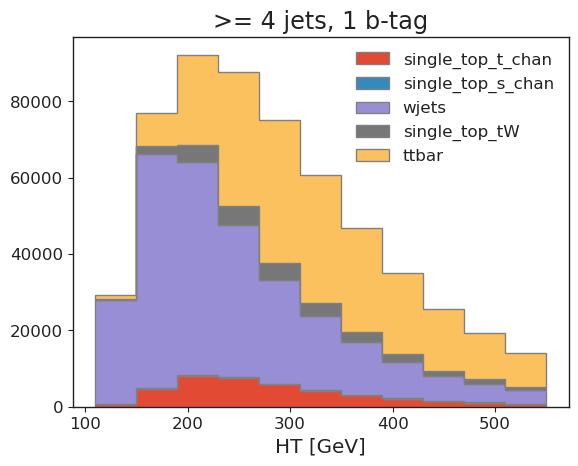

In [9]:
utils.set_style()

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

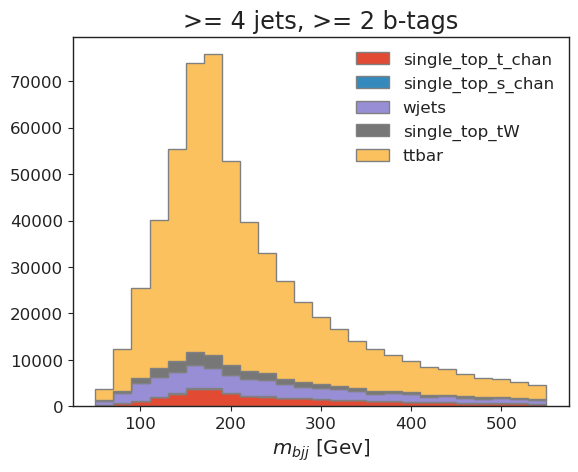

In [10]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("$m_{bjj}$ [Gev]");

Our top reconstruction approach ($bjj$ system with largest $p_T$) has worked!

Let's also have a look at some systematic variations:
- b-tagging, which we implemented as jet-kinematic dependent event weights,
- jet energy variations, which vary jet kinematics, resulting in acceptance effects and observable changes.

We are making of [UHI](https://uhi.readthedocs.io/) here to re-bin.

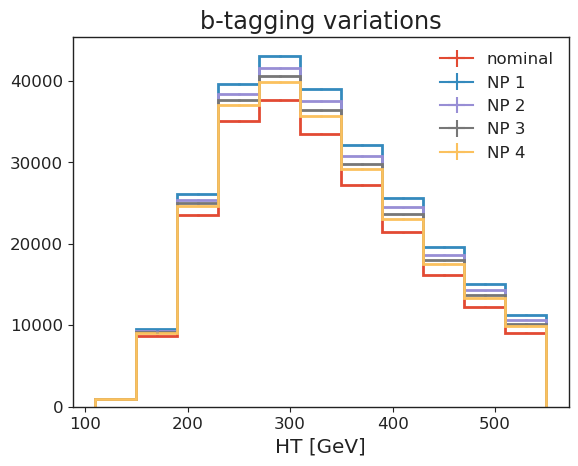

In [11]:
# b-tagging variations
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("HT [GeV]")
plt.title("b-tagging variations");

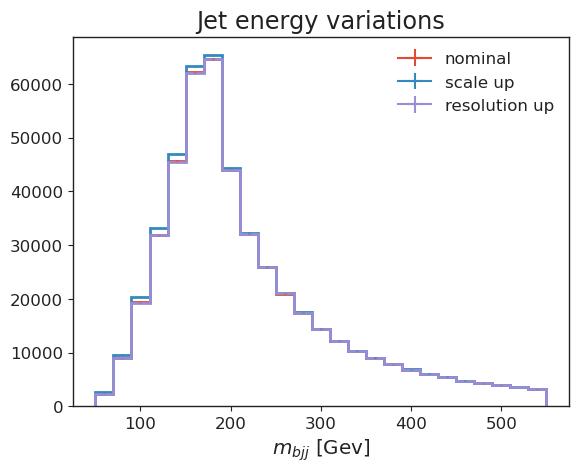

In [12]:
# jet energy scale variations
all_histograms[:, "4j2b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms[:, "4j2b", "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms[:, "4j2b", "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

### Save histograms to disk

We'll save everything to disk for subsequent usage.
This also builds pseudo-data by combining events from the various simulation setups we have processed.

In [13]:
utils.save_histograms(all_histograms, fileset, "histograms.root")

### Statistical inference

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.

In [14]:
config = cabinetry.configuration.load("cabinetry_config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)
cabinetry.workspace.save(ws, "workspace.json")

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


We can inspect the workspace with `pyhf`, or use `pyhf` to perform inference.

In [15]:
!pyhf inspect workspace.json | head -n 20

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
                  Summary       
            ------------------  
               channels  2
                samples  5
             parameters  14
              modifiers  14

               channels  nbins
             ----------  -----
                4j1b CR   11  
                4j2b SR   11  

                samples
             ----------
                 W+jets
  single top, s-channel
  single top, t-channel
                     tW
                  ttbar



Let's try out what we built: the next cell will perform a maximum likelihood fit of our statistical model to the pseudodata we built.

W MnPosDef Matrix forced pos-def by adding to diagonal 0.00898658


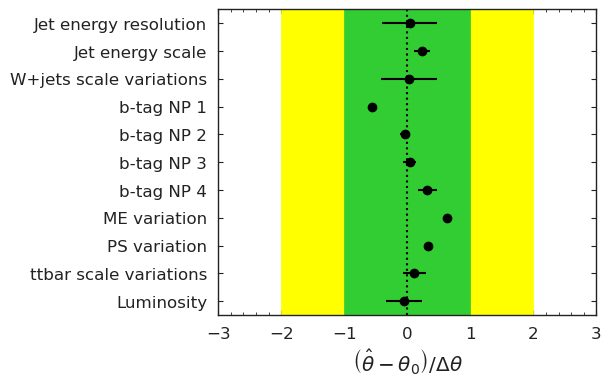

In [16]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

For this pseudodata, what is the resulting ttbar cross-section divided by the Standard Model prediction?

In [17]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 1.028 +/- 0.013


Let's also visualize the model before and after the fit, in both the regions we are using.
The binning here corresponds to the binning used for the fit.

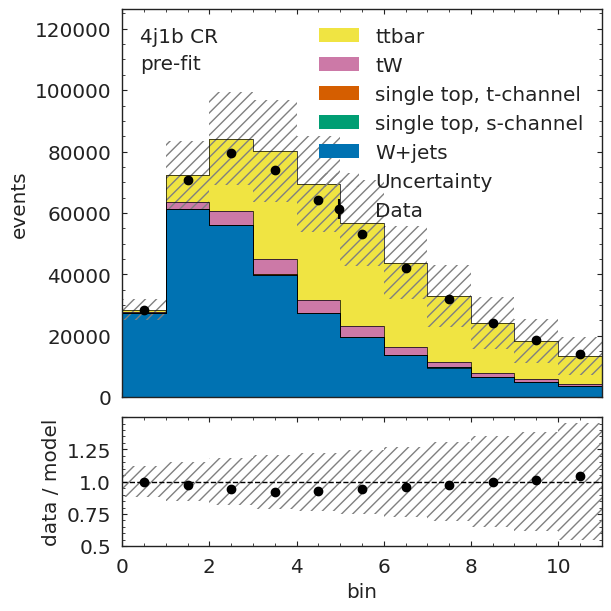

In [18]:
model_prediction = cabinetry.model_utils.prediction(model)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True)
figs[0]["figure"]

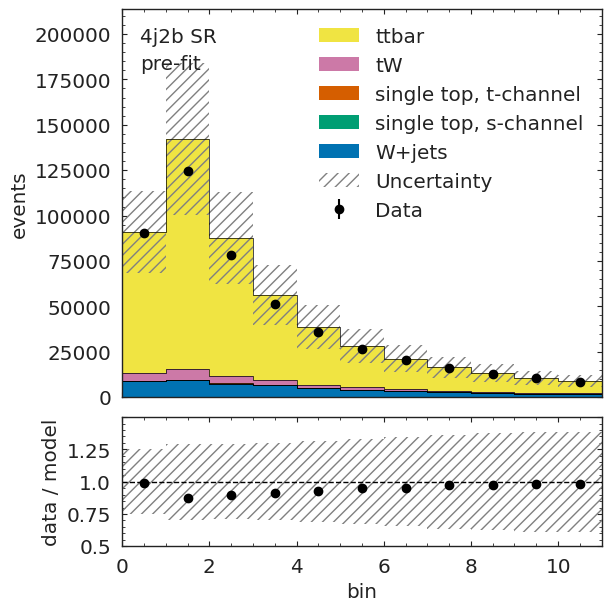

In [19]:
figs[1]["figure"]

We can see very good post-fit agreement.

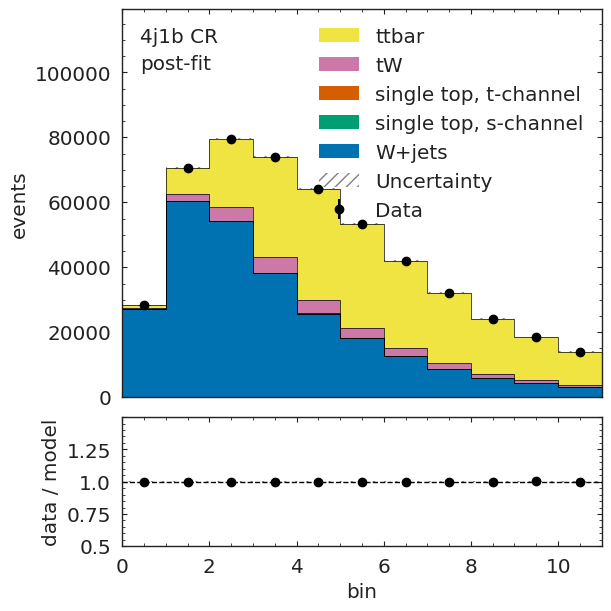

In [20]:
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction_postfit, data, close_figure=True)
figs[0]["figure"]

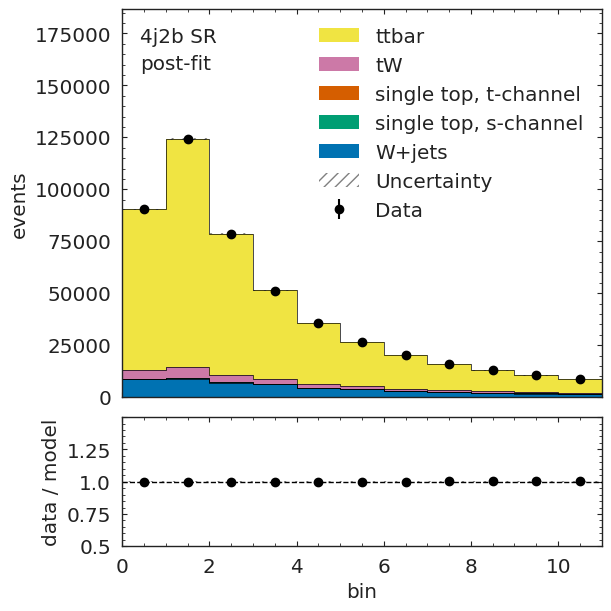

In [21]:
figs[1]["figure"]

### What is next?

Our next goals for this pipeline demonstration are:
- making this analysis even **more feature-complete**,
- **addressing performance bottlenecks** revealed by this demonstrator,
- **collaborating** with you!

Please do not hesitate to get in touch if you would like to join the effort, or are interested in re-implementing (pieces of) the pipeline with different tools!

Our mailing list is analysis-grand-challenge@iris-hep.org, sign up via the [Google group](https://groups.google.com/a/iris-hep.org/g/analysis-grand-challenge).